To demonstrate how our transformation code works, we have set up a sample SQLite database named "sample_225_database.db" to run the code against. To mimic a typical REDCap EAV setup, this database contains the tables sample_redcap_metadata and sample_redcap_data, which have the same structure as the redcap_metadata and redcap_data tables found on a REDCap system. 

To run the demonstration code, you need to have the sqlite3 library installed. This is necessary to execute scripts against an SQLite database.
The script below is used to create, insert and query the sample_redcap_data table. The sample_redcap_data table is the heart of the implementation as it contains all the data associated with the project. For demonstration purposes, we have incorporated the below functionality for a single project with a project_id of 225. But the implementation is designed to be extensible for a wide variety of databases that reside in REDCap. We have included 3 events for demonstration to illustrate how events are managed. The record column has a one-to-one mapping with the patient_id column in the sample_patient_id table. 

Snapshot of sample_redcap_data table is as shown below:


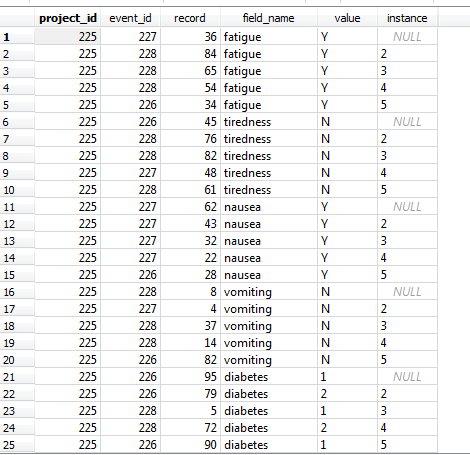

In [4]:
from IPython.display import Image
Image(filename=r"C:\\Users\ad42591\screenshot-srd.PNG")

The function create_table_data creates the sample_redcap_data table, and create_inserts_data inserts data read from the text file sample_redcap_data.txt. The data in the text file is evaluated as a python expression as shown in the code below, where it is read in as a tuple. We are calling the function executemany to perform all the inserts at one go. 

To ensure that all data was inserted successfully, we also execute the select query to verify data insertion.


In [ ]:

import sqlite3
import os


#Connect to SQLite database instance named sample_225_database.db
conn = sqlite3.connect(os.path.expanduser('~') + "\\sample_225_database.db")
c = conn.cursor()


def create_table_data():
    #Query to create table sample_redcap_data
    c.execute('Create table if not exists sample_redcap_data(project_id INTEGER, event_id INTEGER, record INTEGER,field_name text,value text, instance text)')

#Read text file containing tuple of data to be inserted
readinsertdata = open(os.path.expanduser('~') + '\\sample_redcap_data.txt')

#Evaluate the tuple present in the text file as a python expression
readdata = eval(readinsertdata.read())

def create_inserts_data():
    
    #Query to insert data into sample_redcap_data table
    c.executemany('insert into sample_redcap_data(project_id, event_id,record,field_name,value,instance) values(?,?,?,?,?,?)',readdata)
    conn.commit()
    
    # Print the table sample_redcap_data
    c.execute('''SELECT * FROM sample_redcap_data''')
    for row in c:
        print(row)
 
    conn.close()
    c.close()
    conn.close()
    
create_table_data()
create_inserts_data()

The code snippet below is used to create, insert and select the data from the sample_redcap_metadata table. The table contains the form name each field is associated with along with the field_type which is represented by the element_type column. The element_type column contains one of the following three string values: “select”, “radio”, and “checkbox”. The element_enum column contains the descriptions associated with a corresponding enumerated value, with '\n' used as a delimiter. For example, an element_value field containing “1, female \n 2, male” assocates the value “1” with the description “female”, and the value “2” with description “male”.

Snapshot of sample_redcap_metadata table is as shown below:



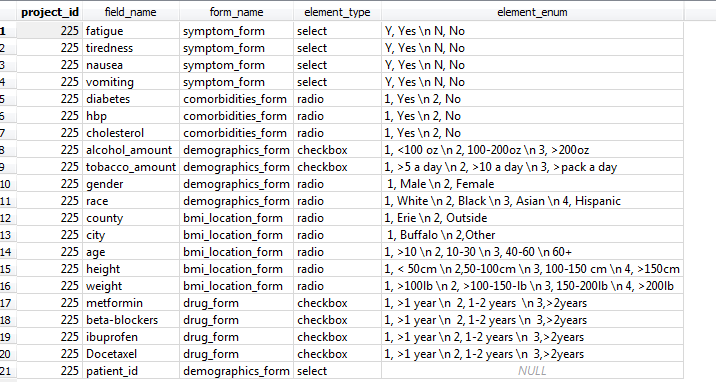

In [8]:
from IPython.display import Image
Image(filename=r"C:\\Users\ad42591\srm.PNG")

The sample_redcap_metadata table is mainly used for joining with the sample_redcap_data table to fetch the form names associated with every field. Although the element_enum column contains descriptions for every enumerate value, the structure of the descriptions makes it very difficult to join and fetch descriptions. In order to overcome this issue, we have created the gt_lookup_sample_data table to join the enumerated values to descriptions. Details about this table are present below.

The function create_table_metadata creates the sample_redcap_metadata table, and create_inserts_metadata inserts data read from the text file sample_redcap_data.txt.


In [ ]:
import sqlite3
import os

#Connect to SQLite database instance named sample_225_database.db
conn = sqlite3.connect(os.path.expanduser('~') + "\\sample_225_database.db")
c = conn.cursor()


def create_table_metadata():
    
    #Create table sample_redcap_metadata
    c.execute('Create table if not exists sample_redcap_metadata(project_id INTEGER, field_name varchar(100), form_name varchar(100),element_type varchar(200),element_enum varchar(200))')

#Read text file named sample_redcap_metadata.txt 
readinsertmeta = open(os.path.expanduser('~') + '\\sample_redcap_metadata.txt')

#Evaluate the tuple being read as a dictionary
readmeta = eval(readinsertmeta.read())

def create_inserts_metadata():
    
    #Insert data into sample_redcap_metadata table
    c.executemany('insert into sample_redcap_metadata(project_id, field_name,form_name,element_type,element_enum) values(?,?,?,?,?)',readmeta)
    conn.commit()
    
    # Print the contents of sample_redcap_metadata table
    c.execute('''SELECT * FROM sample_redcap_metadata''')
    for row in c:
        print(row)
 
    conn.close()
   
   
    
create_table_metadata()
create_inserts_metadata()

The script below contains functions for the creation, insertion and selection of data for the gt_lookup_sample_data table. This table is used to fetch the descriptions of the codes present in the sample_redcap_data table. The descriptions present in the sample_redcap_metadata table are broken down using '\n' as the delimiter such that each value has an associated description.
Viewing data in such a manner is desired while querying data for answering scientific research questions. The descriptions present in this table are fetched in the attribute tables by joining on this table thus making queries very intuitive. 


In [ ]:
import sqlite3
import os

#Connect to database named sample_225_database.db
conn = sqlite3.connect(os.path.expanduser('~') + "\\sample_225_database.db")
c = conn.cursor()


#Create the lookup table
def create_table_lookup():
    c.execute('Create table if not exists gt_lookup_sample_data(project_id INTEGER, form_name varchar(100), field_name varchar(100),code varchar(100), label varchar(200), element_type varchar(200))')

#Read data from the tuple created in text file
readinserts = open(os.path.expanduser('~') + '\\gt_lookup_sample_data.txt')


#Evaluate the tuple being read as a python expression
readfile = eval(readinserts.read())

def create_inserts_lookup():
    
    #Insert data into the lookup table
    c.executemany('insert into gt_lookup_sample_data(project_id, form_name, field_name, code, label, element_type) values(?,?,?,?,?,?)',readfile)
    conn.commit()
    
    # Print the contents of lookup table
    c.execute('''SELECT * FROM gt_lookup_sample_data''')
    for row in c:
        print(row)
 
   
    c.close()
    conn.close()
    
create_table_lookup()
create_inserts_lookup()

The script below is used to create the attribute tables by field names. The base table sample_redcap_data table is split into separate attribute tables such that an attribute table for every field name is created. The script is used to generate SQL queries that create the attribute tables. 
The attribute tables are created for both checkbox and non-checkbox fields. 
Because checkbox fields in REDCap can conceptually represent one-to-many relations, we make a distinction between checkbox and non-checkbox fields. For example, the drug_form allows for multiple drugs to be selected as being taken by a single patient. In the EAV schema, this results in multiple rows. For each drug selected, a row containing the record field and drug value is created.

Snapshot of a single patient consuming more than one drug from the sample_redcap_data table:




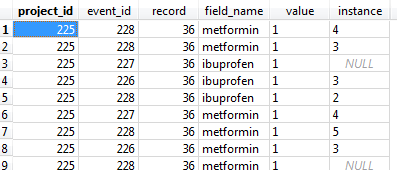

In [9]:
from IPython.display import Image
Image(filename=r"C:\\Users\ad42591\drugs1.PNG")

The script also reads data from two separate csv files where one of the csv files contains the data associated with only checkbox fields and the other contains data associated with only non-checkbox fields.
The script appends the keyword "checkbox_table" for all checkbox fields to provide a clear distinction and the non-checkbox fields' tables start with the string "table". The SQL that is output from this script is to be executed on the preferred SQLite environment (SQLIte command prompt, SQLite Studio, DBVisualizer, etc.). On execution, all the desired attribute tables by field names are generated.

The main advantage of attribute tables (as opposed to views) is that they increase query performance rapidly, since they are small in nature and also play a pivotal role for creating the views based on form names. These form name views are explained in the subsequent sections.


In [ ]:
import sqlite3
import pandas as pd
import getpass

import os



project_id = raw_input("REDCap Project ID#: ")

#function to create views
def create_att_table_sql(project_id):

    #read csv into pandas daraframe
    reqpd = pd.read_csv(os.path.expanduser('~') + '\\sample_data_tables.csv')
    ps = reqpd['field_name'].tolist()


    view_text = ""

    # Fetching fields that have checkboxes
    with open(os.path.expanduser('~') + '\\Samp_dict_cb.txt') as checkboxele:

        checkboxlist = checkboxele.readlines()
        checkboxstr = ",".join(checkboxlist)
        checkstr = checkboxstr.split(",")
        cblist = [x.strip("'") for x in checkstr]

        # Typecasting to set to remove duplicate checkbox fields
        checkboxset = set(cblist)

    # this returns fields that are not checkboxes
    listoffields = list(set(ps).difference(set(cblist)))


    # Iterating through the set of checkbox fields
    # Then, generating a SQL script that creates attribute tables
    # for only those containing checkboxes
    # The string "view_text" returns the query that is used to generate the desired attribute tables.

    for cb in set(checkboxset):
        view_text +=  """\n\n\nDROP TABLE IF EXISTS checkbox_table_""" + str(project_id) + "_" + cb + ";" 
        view_text += """\n\n\nCREATE table checkbox_table_""" + str(project_id) +"""_""" + cb + \
               """ as SELECT d.event_id,d.project_id, d.record, p.patient_id""" + \
                    ",g.form_name,d.field_name,d.value,gt.label,d.instance"""\
        "\nFROM sample_redcap_data d " \
                 "\ninner join sample_redcap_metadata g  " \
        "on g.field_name = d.field_name \n and d.project_id = g.project_id" \
        "\ninner join gt_lookup_sample_data gt on  gt.field_name = d.field_name \n and gt.code = d.value"  \
        "\ninner join sample_patient_id p on p.record = d.record"\
        "\nWHERE d.field_name = " + "'" + cb + "'" +\
                     " \norder by d.record;"


    #get unique fiels_name
    #used for passsing dynamically to the query used for creating views
    setps = set(ps)


    for nocb in listoffields:

        #query to create views dynamically - field_names are dynamically fetched from previous stop
        #The query ensures that rows are not repeated thus preventing data duplication
        #this query logic handles repeating forms
        view_text += """\n\n\nDROP TABLE IF EXISTS table_""" + str(project_id) + "_" + nocb + ";" + \
        """\n\n\nCREATE table table_""" + str(project_id) +"""_""" + nocb + \
              """ as SELECT d.event_id,d.project_id, d.record, p.patient_id""" + \
                    ",g.form_name,d.field_name,d.value,gt.label,d.instance"""\
        "\nFROM sample_redcap_data d " \
                 "\ninner join sample_redcap_metadata g  " \
        "on g.field_name = d.field_name \n and d.project_id = g.project_id" \
        "\ninner join gt_lookup_sample_data gt on  gt.field_name = d.field_name \n and gt.code = d.value"  \
        "\ninner join sample_patient_id p on p.record = d.record"\
        "\nWHERE d.field_name = " + "'" + nocb + "'" +\
                     " \norder by d.record;"

    print view_text
  

create_att_table_sql(225)

The script below fetches the patient id's for every patient. Each patient id has a one-to-one mapping with the record column present in the sample_redcap_table and all the attribute tables. In order to fetch the patient id, we join on the table created below.

In [ ]:
import sqlite3
import os

#Connect to the SQLite database
conn = sqlite3.connect(os.path.expanduser('~') + "\\sample_225_database.db")
c = conn.cursor()


def create_table_patient_id():
    
    #Create table sample_patient_id containing record and associated patient_id
    c.execute('Create table if not exists sample_patient_id(event_id INTEGER, project_id INTEGER, record INTEGER,field_name text,patient_id INTEGER)')

#Read the tuple of patient_id's
readinsertdata = open(os.path.expanduser('~') + '\\sample_patient_id.txt')

#Evaluate the tuple as a python expression
readdata = eval(readinsertdata.read())

def create_inserts_patient_id():
    #Insert data into sample_patient_id table
    c.executemany('insert into sample_patient_id(event_id,project_id,record,field_name,patient_id) values(?,?,?,?,?)',readdata)
    conn.commit()
    
    # Print the contaents of sample_patient_id table
    c.execute('''SELECT * FROM sample_patient_id''')
    for row in c:
        print(row)
 
    conn.close()
    c.close()
    conn.close()
    
create_table_patient_id()
create_inserts_patient_id()

The script below initially use the project_id used for the project. Once the input is read, the function create_view_sql  outputs the SQL query to construct the views by form names. The script generates the queries only for non-checkbox fields (i.e., select, radio) and these fields are identified by reading in a text file named "Samp_dict_no_cb.txt". This text file contains a dictionary of form names as keys and associated field names as values. Then, the contents of text file are evaluated as a python expression.

All the view’s required columns are stored in reqlist variable, which is constructed with a list comprehension, and then type casted into a string to ease query construction. The SQL query to create the views is generated on running the script. This results in an SQL query to create a view for each form, which is then executed on the SQLite environment to create the view.

Sometimes users want to query data like this in a more compact manner. So, we also create a view that groups checkbox values together with a group_concat function.

Snapshot of the usage of group_concat() function on the views for specific patients consuming more than one drug:


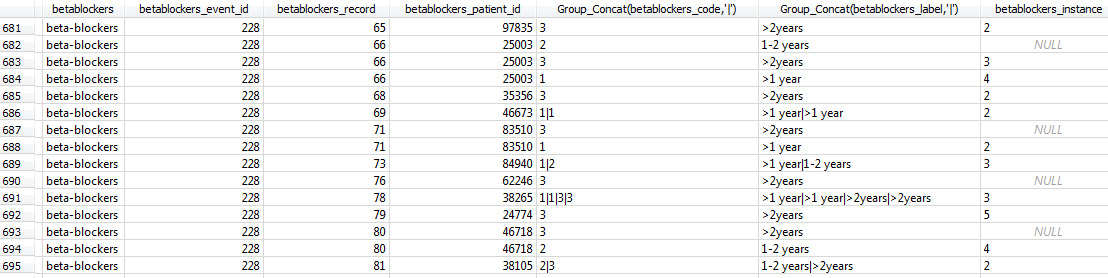

In [10]:
from IPython.display import Image
Image(filename=r"C:\\Users\ad42591\drugs_grouped.PNG")

The script also creates the views by form names for only checkbox fields. It resembles the previous script with the only distinction being the string "checkbox_" prepended to the query string. The dictionary read in contains the form names as keys and the checkbox-field names as values. This results in an SQL query to create a view for each form, which is then executed on the SQLite environment to create the view.

In [ ]:
import sqlite3
import pandas as pd

import os


project_id = raw_input("REDCap Project ID#: ")

#Function that returns dictionary
def dict_read(readdict):

    return readdict

#Functon used to build query string
def view_text_string(vwtext):

    return vwtext

#function to create views
#Functions returns the SQL query string used for creating
#views based on form names. The queries generated are executed and the
#Resulting views are mapped on GeneTegra. They are easy to query as the
#views flip the REDCap data in EAV format  to a relational
#database which is more intuitive to query on and
#easier to query with GeneTegra
def create_view_sql(project_id):

    #This nested function is used to generate the joins
    #with all the field based attribute tables thus
    #resulting in a view that is based on form names
    #where in the form contains all the fields associated
    #with itself
    def cond_diff():
        countnumgen = 0
        for i in v:
            countnumgen += 1
            strct = str(countnumgen)
            if type(i) == str:

                joinstr = "\n LEFT JOIN table_" + str(project_id) + i + " t" + strct + \
                          "\n ON ((f.instance = " + i + "_instance) or " \
                           "(f.instance is null and " + i + "_instance is null)) \n " \
                            "and f.record = " + i + "_record \n "\
                            "and f.event_id = " + i + "_event_id"
                print joinstr

    #read csv into pandas daraframe
    reqpd = pd.read_csv(os.path.expanduser('~') + '\\sample_data_tables.csv')
    ps = reqpd['form_name'].tolist()


    #This text file is used to read a dictionary of both checkbox and non checkbox fields.
    #The argument to the dict_read() function neeeds to be changed based on
    #the dictionary being read based on checkbox/ non- checkbox fields.
    dictread = open(os.path.expanduser('~') + dict_read("\\Samp_dict_no_cb.txt"))

    empd = eval(dictread.read())

    #Typecasted to set
    setps = set(ps)

    view_text  = ""

    #Loop through the dictionary to fetch the desired fields and append
    #strings based on field names
    for k,v in empd.iteritems():

        reqlist =  [s + "," + s + "_event_id" + ","  + s + "_record" + "," + s + "_patient_id" + "," + s + "_label" + "," + s + "_instance" for s in v[1:]]
        reqstr = ",".join(reqlist)

        #The argument passed to the dict_read() function depends on
        #whether the checkbox/non-checkbox dictionary is being read.
        #Needs to be changed accordingly
        if dict_read("\\Samp_dict_no_cb.txt"):

            #The query string needed. Remove "_checkbox" for non checkbox fields
            view_text =  view_text_string("""\n\n\nDrop view if exists """) + k + ";" + "\n\n\nCREATE view """  + k + \
                                                         """ as SELECT distinct """ + reqstr + \
                     "\nFROM form_samp_join f "
            print view_text

            #Calling cond_diff() function to concatenate the joins with the "create view query"
            #To generate the desired query string
            cond_diff()
    

    return view_text

create_view_sql(225)


The script below is used to create the views by form names for only checkbox fields. It resembles the script above with the only distinction being the string "checkbox_" prepended to the query string. The dictionary read in contains the form names as keys and the checkbox-field names as values. The output obtained on running the script is a bunch of "create" view statements which should be executed on the SQLite environment to create the views.

In [ ]:
import sqlite3
import pandas as pd


import os


project_id = raw_input("REDCap Project ID#: ")

#Function that returns dictionary
def dict_read(readdict):

    return readdict

#Functon used to build query string
def view_text_string(vwtext):

    return vwtext

#function to create views
#Functions returns the SQL query string used for creating
#views based on form names. The queries generated are executed and the
#Resulting views are mapped on GeneTegra. They are easy to query as the
#views flip the REDCap data in EAV format  to a relational
#database which is more intuitive to query on and
#easier to query with GeneTegra
def create_view_sql(project_id):

    #This nested function is used to generate the joins
    #with all the field based attribute tables thus
    #resulting in a view that is based on form names
    #where in the form contains all the fields associated
    #with itself
    def cond_diff():
        countnumgen = 0
        for i in v:
            countnumgen += 1
            strct = str(countnumgen)
            if type(i) == str:

                joinstr = "\n LEFT JOIN checkbox_table_" + str(project_id) + i + " t" + strct + \
                          "\n ON ((f.instance = " + i + "_instance) or " \
                           "(f.instance is null and " + i + "_instance is null)) \n " \
                            "and f.record = " + i + "_record \n "\
                            "and f.event_id = " + i + "_event_id"
                print joinstr

    #read csv into pandas daraframe
    reqpd = pd.read_csv(os.path.expanduser('~') + '\\sample_data_tables.csv')
    ps = reqpd['form_name'].tolist()


    #This text file is used to read a dictionary of both checkbox and non checkbox fields.
    #The argument to the dict_read() function neeeds to be changed based on
    #the dictionary being read based on checkbox/ non- checkbox fields.
    dictread = open(os.path.expanduser('~') + dict_read("\\Samp_dict_checkboxes.txt"))

    empd = eval(dictread.read())

    #Typecasted to set
    setps = set(ps)

    view_text  = ""

    #Loop through the dictionary to fetch the desired fields and append
    #strings based on field names
    for k,v in empd.iteritems():

        reqlist =  [s + "," + s + "_event_id" + ","  + s + "_record" + "," + s + "_patient_id"  + "," + "Group_Concat(" + s +  "_code" +"," + "'" + "|" + "'" + ")" + "," + "Group_Concat(" + s +  "_label" +"," + "'" + "|" + "'" + ")" + "," + s + "_instance" for s in v[1:]]
        reqstr = ",".join(reqlist)
        lstgroupby = [s + "," + s + "_event_id" + ","  + s + "_record" + "," + s + "_patient_id"  + "," + s + "_instance" for s in v[1:]]
        strgroupby = ','.join(lstgroupby)
        
        
        #The argument passed to the dict_read() function depends on
        #whether the checkbox/non-checkbox dictionary is being read.
        #Needs to be changed accordingly
        if dict_read("\\Samp_dict_cb.txt"):

            #The query string needed. Remove "_checkbox" for non checkbox fields
            view_text =  view_text_string("""\n\n\nDrop view if exists """) + k + ";" + "\n\n\nCREATE view """  + k + \
                                                         """ as SELECT distinct """ + reqstr + \
                     "\nFROM form_samp_join f "
            print view_text

            #Calling cond_diff() function to concatenate the joins with the "create view query"
            #To generate the desired query string
            cond_diff()
            groupbystr = "Group by " + strgroupby + ';'
            print groupbystr
     
    

    return view_text

create_view_sql(225)
